<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Convolutional Neural Network (CNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu102].
device:[cuda:0].


### Dataset

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [5]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self,name='cnn',xdim=[1,28,28],
                 ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                nn.Conv2d(
                    in_channels=prev_cdim,
                    out_channels=cdim,
                    kernel_size=self.ksize,
                    stride=(1,1),
                    padding=self.ksize//2)) # convlution 
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling 
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim,hdim,bias=True))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)
        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
    hdims=[32],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


### Check Parameters

In [6]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[ 1.021 -0.437 -0.057 -0.036  0.054]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[-0.01   0.021  0.005 -0.103  0.14 ]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.023  0.002  0.05   0.    -0.019]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[-0.028 -0.196 -0.168 -0.154 -0.312]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


### Simple Forward Path of the CNN Model

In [7]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


x_torch:
 tensor([[[[0.950, 0.982, 0.881,  ..., 0.894, 0.469, 0.939],
          [0.392, 0.494, 0.919,  ..., 0.495, 0.649, 0.121],
          [0.656, 0.979, 0.999,  ..., 0.086, 0.528, 0.508],
          ...,
          [0.116, 0.237, 0.075,  ..., 0.139, 0.005, 0.383],
          [0.919, 0.219, 0.928,  ..., 0.389, 0.137, 0.911],
          [0.723, 0.466, 0.527,  ..., 0.344, 0.256, 0.765]]],


        [[[0.589, 0.992, 0.485,  ..., 0.803, 0.520, 0.549],
          [0.522, 0.593, 0.231,  ..., 0.376, 0.539, 0.132],
          [0.825, 0.032, 0.561,  ..., 0.815, 0.353, 0.790],
          ...,
          [0.472, 0.239, 0.640,  ..., 0.299, 0.205, 0.617],
          [0.063, 0.414, 0.177,  ..., 0.745, 0.785, 0.080],
          [0.152, 0.749, 0.952,  ..., 0.172, 0.319, 0.704]]]], device='cuda:0')
y_torch:
 tensor([[ 0.058, -2.091,  2.654,  0.089, -1.972, -2.416, -1.842, -1.852, -1.163,
          0.944],
        [ 2.409, -0.824,  0.842, -1.075,  0.601, -1.094, -2.807,  0.151, -1.028,
         -0.102]], device=

### Evaluation Function

In [8]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [9]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.092] test_accr:[0.094].


### Train

In [11]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.528] train_accr:[0.959] test_accr:[0.963].
epoch:[1] loss:[0.162] train_accr:[0.977] test_accr:[0.977].
epoch:[2] loss:[0.119] train_accr:[0.981] test_accr:[0.983].
epoch:[3] loss:[0.099] train_accr:[0.985] test_accr:[0.983].
epoch:[4] loss:[0.085] train_accr:[0.987] test_accr:[0.985].
epoch:[5] loss:[0.077] train_accr:[0.987] test_accr:[0.987].
epoch:[6] loss:[0.072] train_accr:[0.990] test_accr:[0.987].
epoch:[7] loss:[0.062] train_accr:[0.989] test_accr:[0.987].
epoch:[8] loss:[0.060] train_accr:[0.992] test_accr:[0.989].
epoch:[9] loss:[0.055] train_accr:[0.993] test_accr:[0.989].
Done


### Test

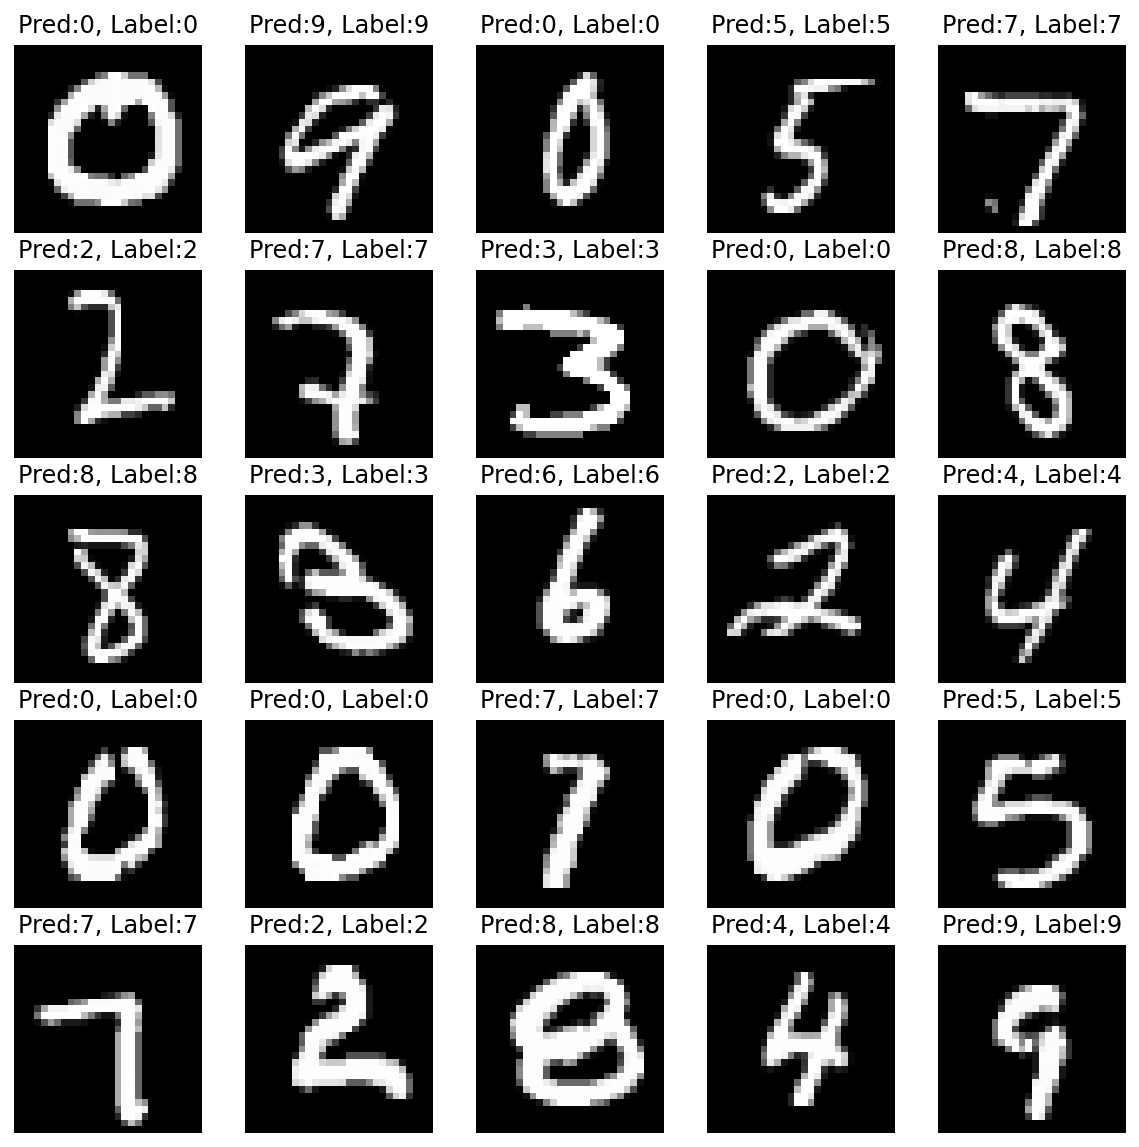

Done


In [13]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")